FFNN model

Team Members: Akhila Ganti, Megan Nguyen, Leslie Nie, Kevin Stallone, and Tim Tung 
Github Repo: https://github.com/UC-Berkeley-I-School/mids-207-final-project-summer23-Tung-Ganti-Nie-Nguyen-Stallone.git

Project Description

The goal of this project is to predict if a person has any of three age-related medical conditions. To assess, we will create a model trained on measurements of health characteristics.

Motivation

"Aging is a risk factor for numerous diseases and complications. The growing field of bioinformatics includes research into interventions that can help slow and reverse biological aging and prevent major age-related ailments. Data science could have a role to play in developing new methods to solve problems with diverse data, even if the number of samples is small."

Data Source

Data is sourced from an active (June 2023) Kaggle competition: https://www.kaggle.com/competitions/icr-identify-age-related-conditions/overview

In [1]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

# For hyperparameter tuning
import keras_tuner
from tensorflow import keras

# Unused atm
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from mlxtend.plotting import heatmap
from pykeen.ablation import ablation_pipeline

# Stats library
import statsmodels.api as sm

#from .autonotebook import tqdm as notebook_tqdm

# shap
import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from tabulate import tabulate

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

random.seed(2)
%matplotlib inline

/Users/akhilaganti/anaconda3/lib/python3.10/site-packages/pykeen/evaluation/evaluator.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
greeks = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/greeks.csv')
train = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/train.csv')
test = pd.read_csv('/Users/akhilaganti/UCB_MIDS_w207/Final_Project/test.csv')

greeks.columns = map(str.lower, greeks.columns)
train.columns = map(str.lower, train.columns)
test.columns = map(str.lower, test.columns)

print('greeks data:', greeks.shape)
print('train data:', train.shape)
print('test data:', test.shape)

# Merge train and greeks to get all columns in the same DataFrame
#df = pd.merge(train, greeks, on='id')

greeks data: (617, 6)
train data: (617, 58)
test data: (5, 57)


In [3]:
# One-hot encode EJ so it could be used in tSNE or PCA
train = train.join(pd.get_dummies(train['ej'], dtype=int))
train.drop(['ej'], axis=1, inplace=True)

# Binary target variable
target_variable = train['class']
features_variable = train.drop(['class', 'id'], axis=1)

# Fill in NaN values via KNNImputer
imputer = KNNImputer(n_neighbors=2)
features_variable = pd.DataFrame(imputer.fit_transform(features_variable))

In [4]:
#train.dropna(axis=0, inplace=True)
train.shape

(617, 59)

In [5]:
# Use PCA to reduce features
# Split into Train and Test
num_features = 25
data_split = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(features_variable, target_variable, test_size = data_split,
                                                            stratify=target_variable, random_state=0)
# Standardize values via StandardScaler
sc = StandardScaler().fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# PCA
pca = PCA(n_components = num_features)
pca.fit(X_train_std)
X_train_pca = pd.DataFrame(pca.transform(X_train_std))
X_test_pca = pd.DataFrame(pca.transform(X_test_std))


In [6]:
X_train.shape

(493, 57)

In [7]:
X_train_pca.shape

(493, 25)

In [8]:
Y_train.shape

(493,)

In [9]:
X_test.shape

(124, 57)

In [10]:
X_test_pca.shape

(124, 25)

In [11]:
Y_test.shape

(124,)

In [12]:
display(X_train_pca.head())

# Display old features shape
display(features_variable.shape)

# Display new tSNE features shape
display(X_train_pca.shape)

0         1         2         3         4         5         6    
0 -0.690887  0.685788  1.006226 -1.171854  0.136816  0.093421 -0.481733  \
1 -0.441772  0.454223  1.462607 -0.617965 -0.293618  0.023432  0.153689   
2  0.671402 -1.941961 -1.723888  0.351624  0.629489  1.202796  1.880502   
3 -1.129595 -1.193760  1.500116 -0.829614  0.123395  0.421081  1.446770   
4 -0.449661  0.533336 -2.227092  1.630291 -0.744035 -0.592698  0.645509   

         7         8         9   ...        15        16        17        18   
0  0.392191 -0.176123 -0.091700  ... -1.056261  0.535441  1.200978 -0.158611  \
1 -1.660740 -0.165092  0.878005  ... -1.216243  0.658438  0.838084  0.360564   
2  1.530765 -0.002930  0.937556  ...  0.823074 -0.526456 -0.124357 -0.583080   
3 -1.168590  0.334539  0.943517  ... -0.061908 -0.002122 -0.511413  0.160301   
4 -0.155894 -1.008784  0.356228  ...  0.171670  0.285349  0.590511 -0.380552   

         19        20        21        22        23        24  
0 -0.077590 -0.139836 -0.224102 -0.726805 -0.018811 -0.217810  
1 -0.085385 -0.239045 -0.435239 -0.537305 -0.387489 -0.513291  
2 -0.040892  0.021261  1.472451 -0.945578  0.924031  0.526594  
3  0.051340 -1.812252  0.043625  0.140780 -0.521942  0.504511  
4 -0.343775 -0.816738 -0.552360 -0.553257 -0.493903 -0.271289  

[5 rows x 25 columns]

(617, 57)

(493, 25)

Model

In [13]:
def build_model(hidden_layer_sizes=[],
                activation='relu',
                optimizer='Adam',
                learning_rate=0.01,
                dropout_rate=0.1):
    
    """Build a binary-class logistic regression model using Keras.

    Args:
      hidden_layer_sizes: A list with the number of units in each hidden layer.
      activation: The activation function to use for the hidden layers.
      optimizer: The optimizer to use (SGD, Adam).
      learning_rate: The desired learning rate for the optimizer.

    Returns:
      model: A tf.keras model (graph).
    """
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Create hidden layers with dropout layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=layer_size,activation=activation))
        
        # Add dropout layer for regularization
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))
  
    # Specify optimizer
    if optimizer == 'Adam':
                selected_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model


In [14]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='relu',
                       optimizer='Adam',
                       learning_rate=0.01,
                       dropout_rate=0.1,
                       num_epochs=5,
                       num_folds=10):

  # Address the class imbalances by using class weights.
  # Scaling by total/2 helps keep the loss to a similar magnitude.
  # The sum of the weights of all examples stays the same.
    weight_for_0 = (1 / Y_train.value_counts()[0]) * (Y_train.size / 2.0)
    weight_for_1 = (1 / Y_train.value_counts()[1]) * (Y_train.size / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
  # Create a k-fold object with k subsets
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=0)

  # Create a list to hold the accuracy for each k-fold.
    accuracy_history = []
    
  # Iterate over the k subsets
    for train_index, test_index in kfold.split(X_train_pca):
        X_train_k, X_test_k = X_train_pca.iloc[train_index], X_train_pca.iloc[test_index]
        Y_train_k, Y_test_k = Y_train.iloc[train_index], Y_train.iloc[test_index]
 
        # Build the model.
        model = build_model(hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate,
                      dropout_rate=dropout_rate)

        # Train the model.
        print('Training...')
        history = model.fit(
            x=X_train_k,                # our binary training examples
            y=Y_train_k,                # corresponding binary labels
            epochs=num_epochs,        # number of passes through the training data
            batch_size=32,            # mini-batch size for SGD
            validation_split=0.2,     # use a fraction of the examples for validation
            verbose=0,                # do not display progress output during training
            class_weight=class_weight # use the calculated class weights to address the imbalance
            )

        ######
        #
        # Do you run evaluate on (X_test, Y_test) or (X_test_k, Y_test_k)?
        #
        ######
        
        # Calculate the accuracy of the model
        test_accuracy = model.evaluate(x=X_test_pca, y=Y_test, verbose=0,
                                 return_dict=True)['binary_accuracy']

        print(f'Accuracy: {test_accuracy}')
        
        # Add the accuracy to the history list
        accuracy_history.append(test_accuracy)
        
        # Plot the loss and accuracy
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
        ax1, ax2 = axes.ravel()

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        ax1.plot(train_loss, label='train_loss')
        ax1.plot(val_loss, label='validation loss')
        ax1.set_xticks(range(num_epochs))
        ax1.set_xlabel('Train epochs')
        ax1.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax1.legend()

        train_accuracy = history.history['binary_accuracy']
        val_accuracy = history.history['val_binary_accuracy']
        ax2.plot(train_accuracy, label='train_accuracy')
        ax2.plot(val_accuracy, label='validation accuracy')
        ax2.set_xticks(range(num_epochs))
        ax2.set_xlabel('Train epochs')
        ax2.set_xticks(np.arange(0, num_epochs+1, 10.0))
        ax2.legend()

        plt.show()
    
    # Print the model summary.
    print(model.summary())
    
    # Print the average accuracy of the k folds.
    print(f'Average Accuracy: {sum(accuracy_history) / len(accuracy_history)}')
    
    return model

In [15]:
def build_and_tune_model(hp):
    
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Use Keras Sequential API to build the model
    model = tf.keras.Sequential()
    
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f'units_{i}', min_value=5, max_value=100, step=5),
            activation=hp.Choice('activation', ['relu', 'tanh'])
            ))        
        
    # Choose whether to include a dropout layer and tune the dropout rate
    if hp.Boolean('dropout'):
        model.add(tf.keras.layers.Dropout(rate=(hp.Int('dropout_rate', min_value=10, max_value=50, step=5))*0.01))
        
    # Create output layer
    model.add(tf.keras.layers.Dense(
          units=1,  # output dim for binary classification problem
          use_bias=True,
          activation='sigmoid', # sigmoid rather than softmax for a binary classification problem
          kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          bias_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
          name='Output'
    ))

    # For tuning the learning rate
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")              
                  
    # Specify optimizer

    # Only using Adam optimizer if using PCA.
    optimizer = 'Adam'
    
    if optimizer == 'Adam':
        selected_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        selected_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Using Binary Crossentropy loss
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                optimizer=selected_optimizer, 
                metrics=[tf.keras.metrics.binary_accuracy])

    return model

# Tune the model
build_and_tune_model(keras_tuner.HyperParameters())

# Set up tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_and_tune_model,
    objective="val_loss",
    max_trials=300,
    executions_per_trial=3,
    overwrite=True,
    directory="my_dir",
    project_name="ICR",
)

# Display the tuner search space
tuner.search_space_summary()

# Start tuning - Can specify the number of epochs here.
tuner.search(X_train, Y_train, epochs=10, validation_data=(X_test, Y_test))

# Report tuning results
tuner.results_summary()

Trial 30 Complete [00h 00m 08s]
val_loss: 0.4630042513211568

Best val_loss So Far: 0.4523685077826182
Total elapsed time: 00h 03m 29s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir/ICR
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
num_layers: 3
units_0: 30
activation: tanh
dropout: False
lr: 0.006404687722635315
units_1: 50
dropout_rate: 45
units_2: 65
Score: 0.4523685077826182

Trial 26 summary
Hyperparameters:
num_layers: 2
units_0: 95
activation: tanh
dropout: False
lr: 0.00977060690028708
units_1: 55
dropout_rate: 10
units_2: 40
Score: 0.45413122574488324

Trial 20 summary
Hyperparameters:
num_layers: 1
units_0: 25
activation: tanh
dropout: True
lr: 0.006771864336530797
units_1: 20
dropout_rate: 30
units_2: 35
Score: 0.4603659411271413

Trial 29 summary
Hyperparameters:
num_layers: 3
units_0: 20
activation: tanh
dropout: True
lr: 0.003269038958697772
units_1: 20
dropout_rate: 25
units_2: 100
Score: 0.

Training...
Accuracy: 0.8870967626571655


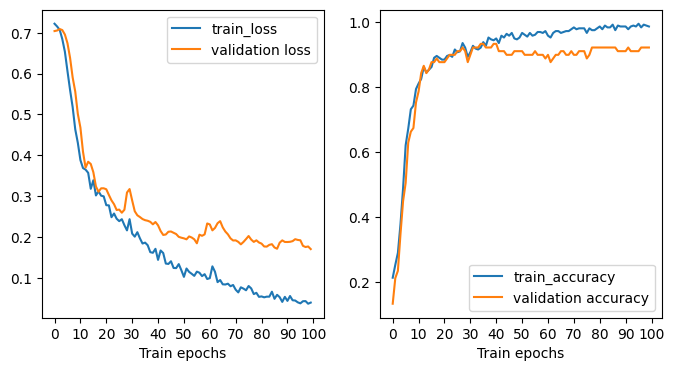

Training...
Accuracy: 0.8709677457809448


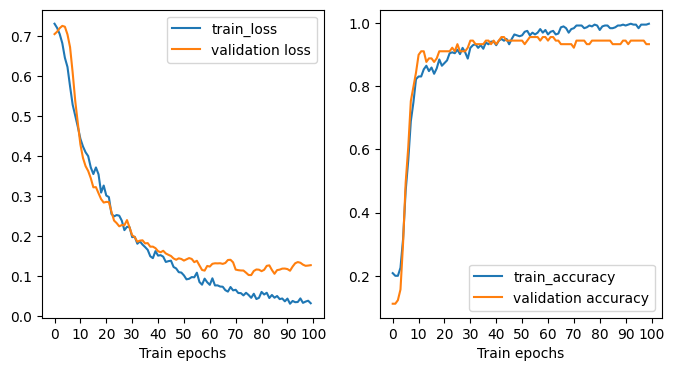

Training...
Accuracy: 0.8951612710952759


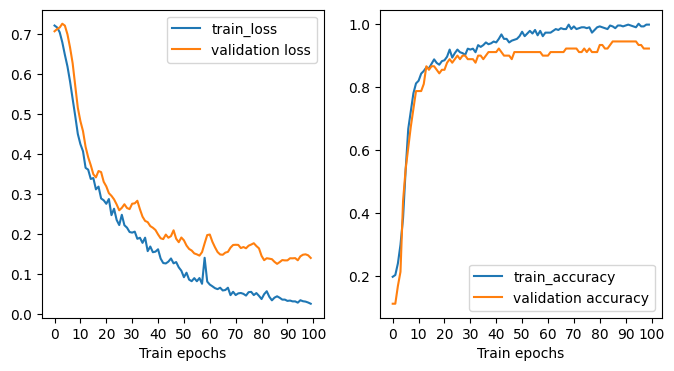

Training...
Accuracy: 0.9032257795333862


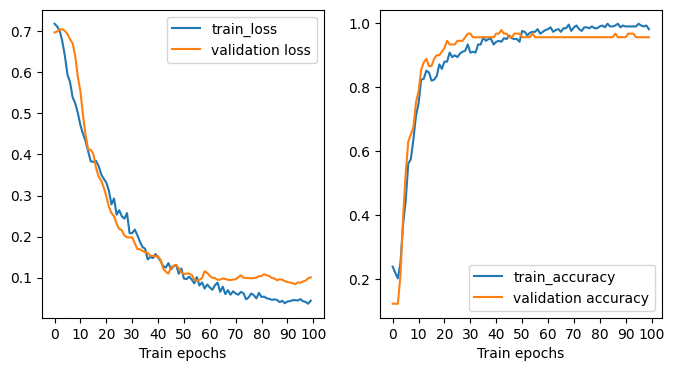

Training...
Accuracy: 0.8870967626571655


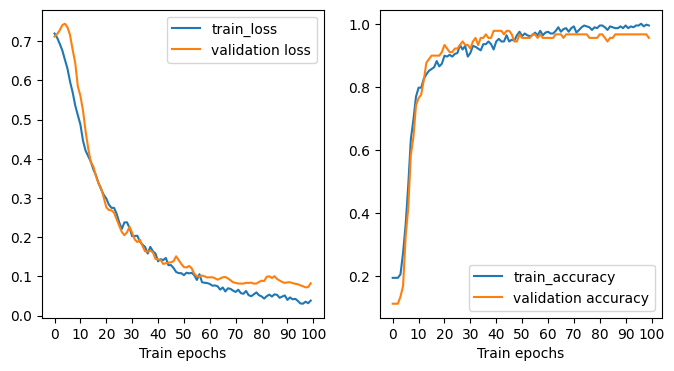

Training...
Accuracy: 0.8790322542190552


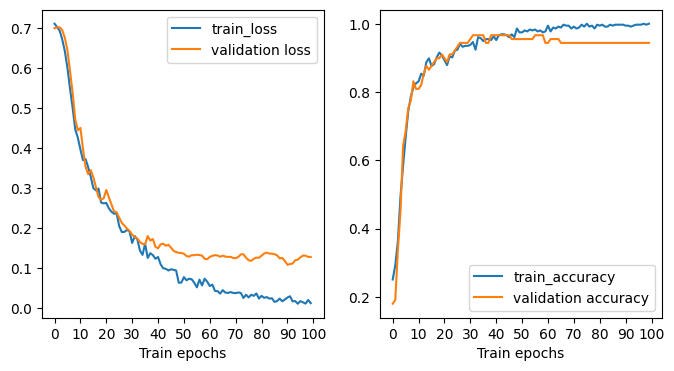

Training...
Accuracy: 0.8790322542190552


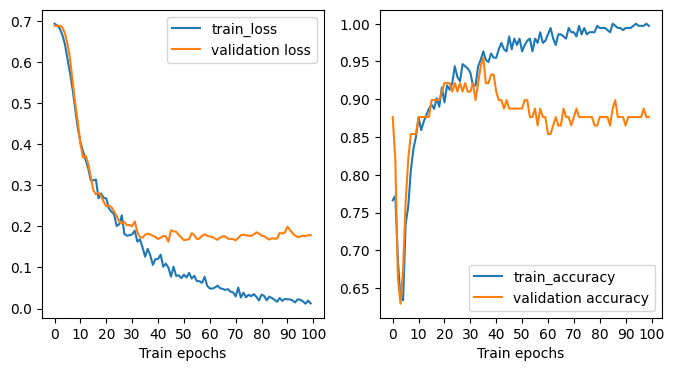

Training...
Accuracy: 0.8629031777381897


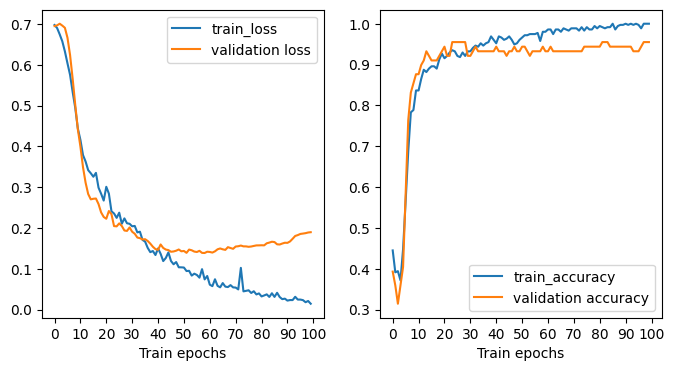

Training...
Accuracy: 0.846774160861969


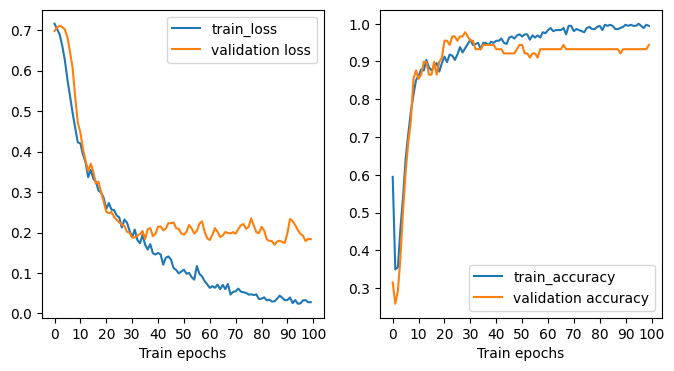

Training...
Accuracy: 0.8870967626571655


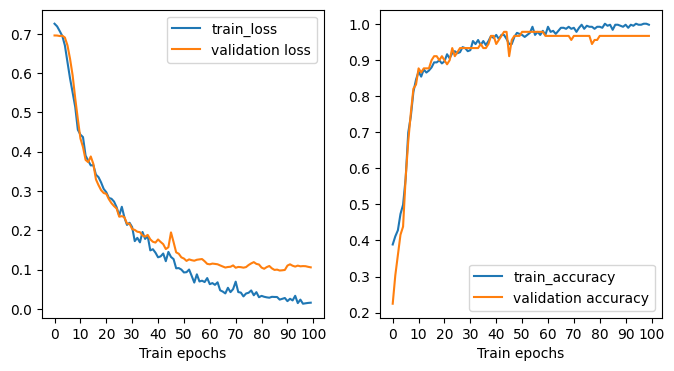

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8798386931419373


In [16]:
# train_and_evaluate(
#     hidden_layer_sizes=[95,10],
#     activation='relu',
#     optimizer='Adam',
#     learning_rate=0.0012104,
#     dropout_rate=0.25,
#     num_epochs=100,
#     num_folds=10)

Training...
Accuracy: 0.8629031777381897


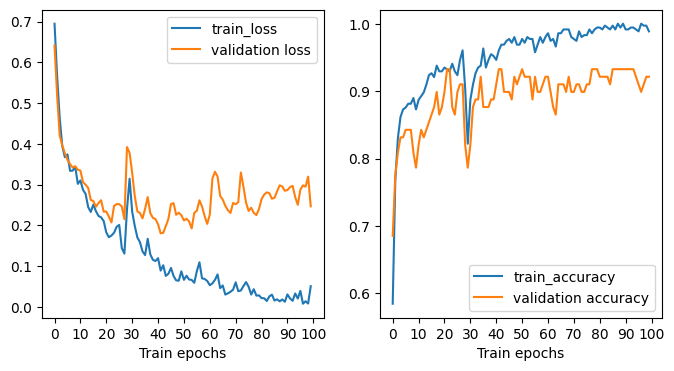

Training...
Accuracy: 0.9032257795333862


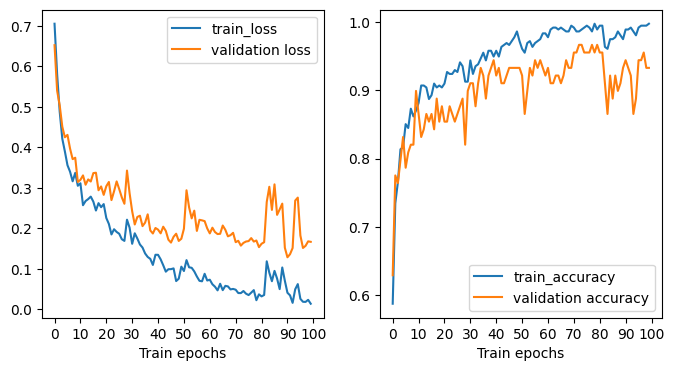

Training...
Accuracy: 0.8548386693000793


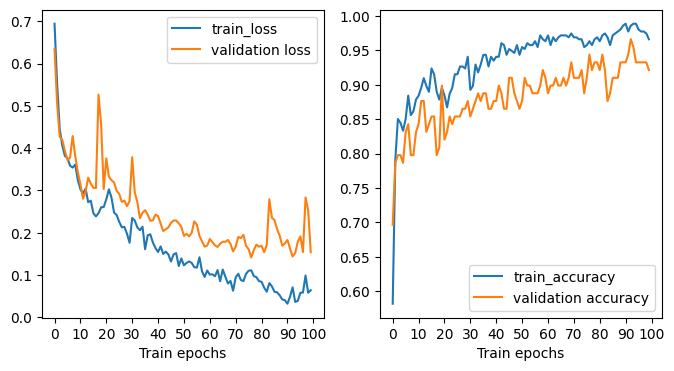

Training...
Accuracy: 0.8548386693000793


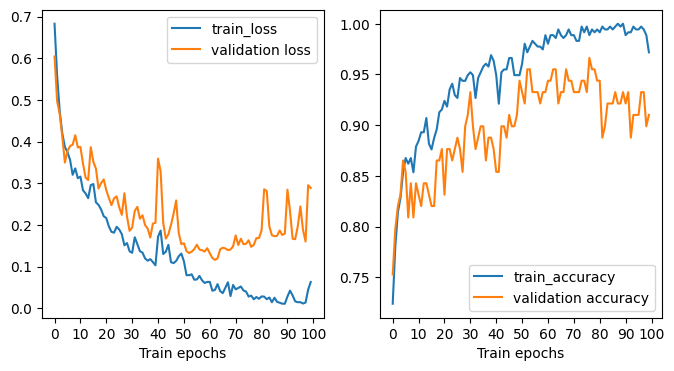

Training...
Accuracy: 0.9032257795333862


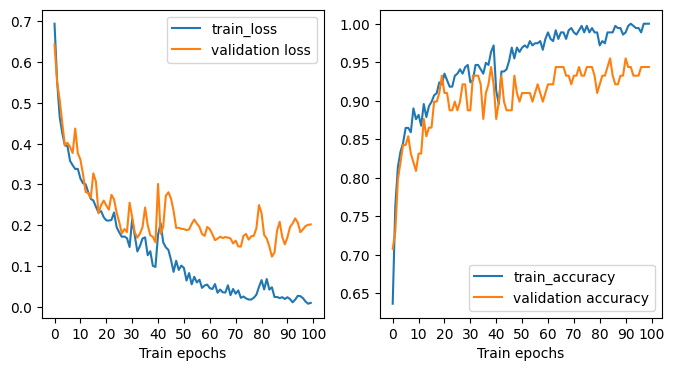

Training...
Accuracy: 0.8951612710952759


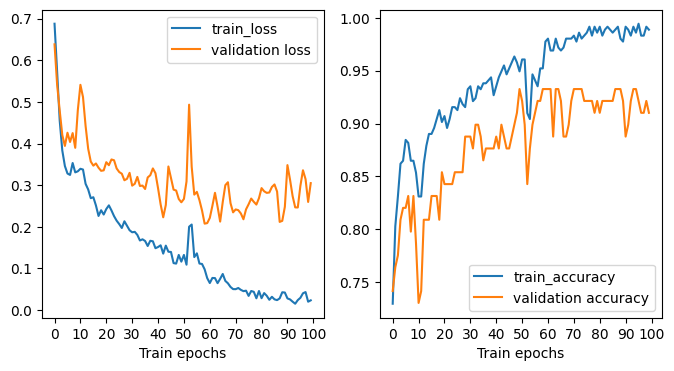

Training...
Accuracy: 0.8790322542190552


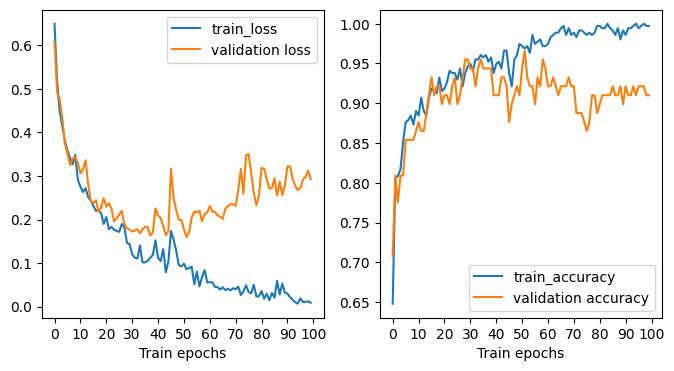

Training...
Accuracy: 0.8870967626571655


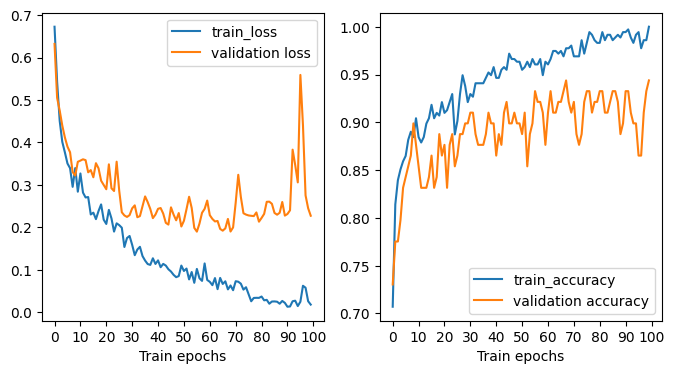

Training...
Accuracy: 0.8709677457809448


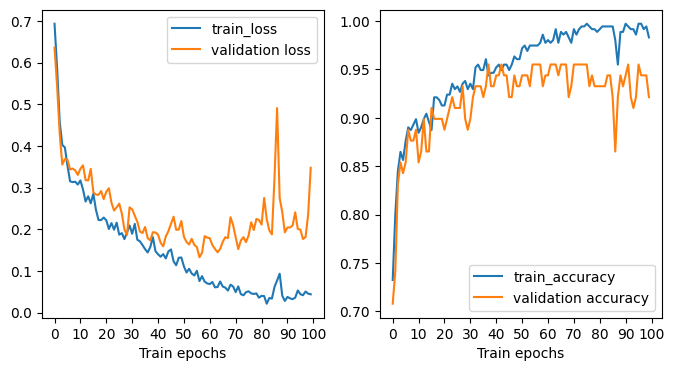

Training...
Accuracy: 0.8870967626571655


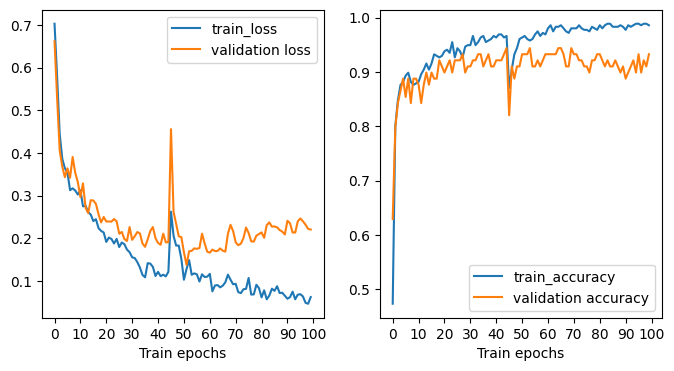

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8798386871814727


In [30]:
# train_and_evaluate(
#      hidden_layer_sizes=[100,10],
#      activation='tanh',
#      optimizer='Adam',
#      learning_rate=0.006404687722635315,
#      dropout_rate=0.25,
#      num_epochs=100,
#      num_folds=10)

Training...
Accuracy: 0.8629031777381897


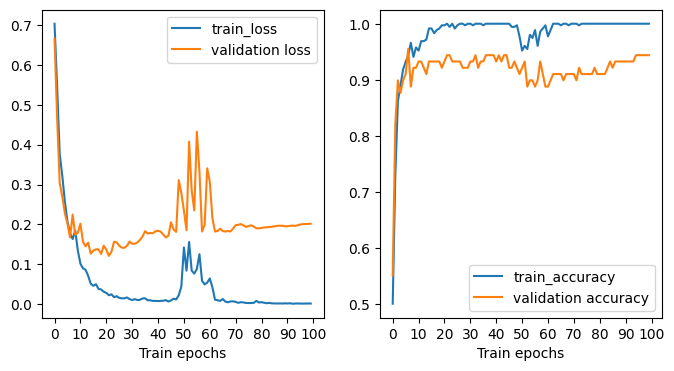

Training...
Accuracy: 0.8709677457809448


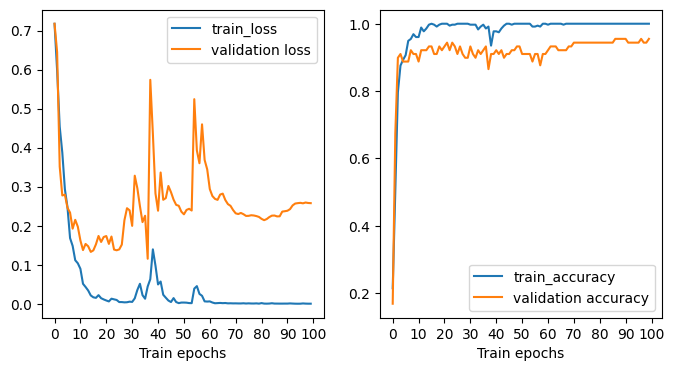

Training...
Accuracy: 0.9032257795333862


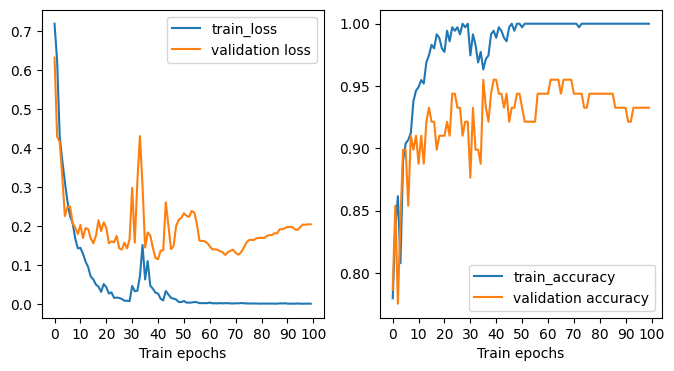

Training...
Accuracy: 0.8870967626571655


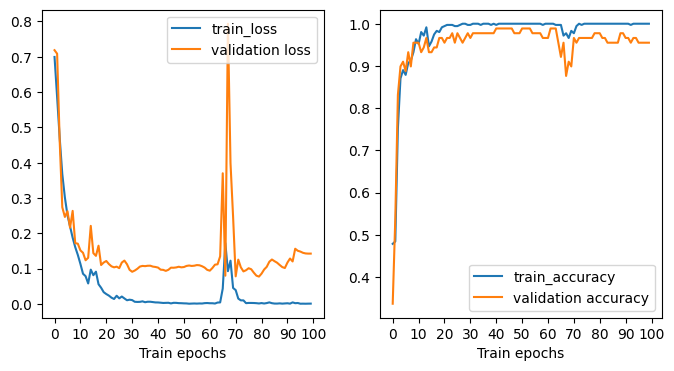

Training...
Accuracy: 0.8951612710952759


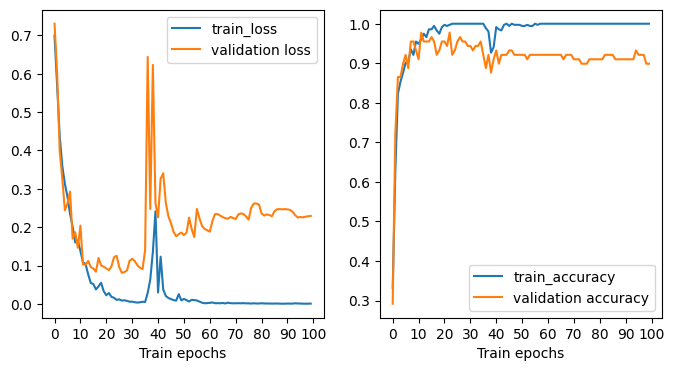

Training...
Accuracy: 0.8870967626571655


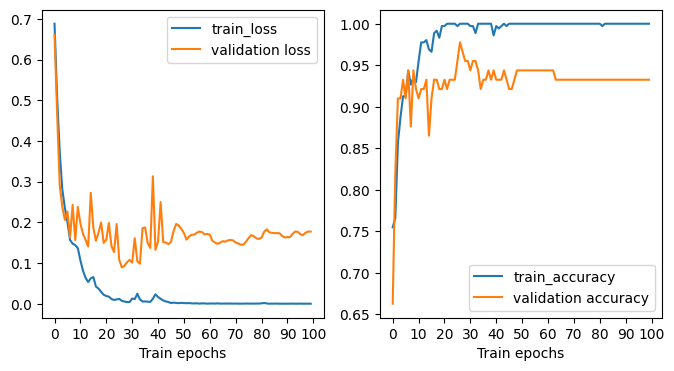

Training...
Accuracy: 0.8709677457809448


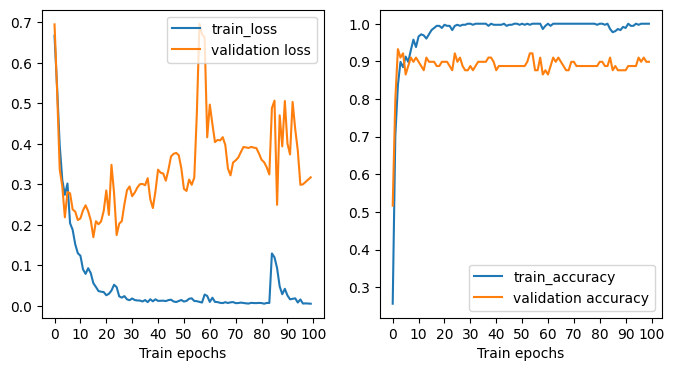

Training...
Accuracy: 0.8790322542190552


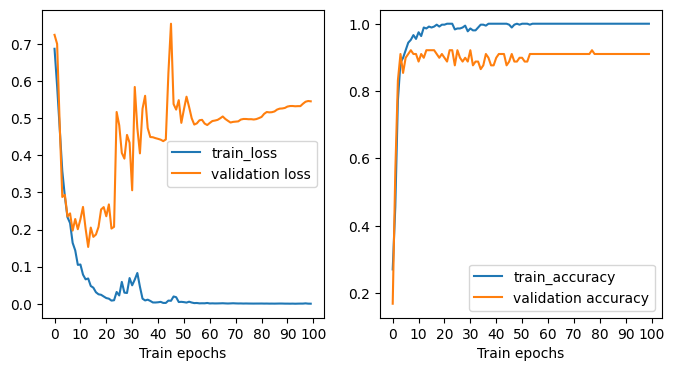

Training...
Accuracy: 0.8709677457809448


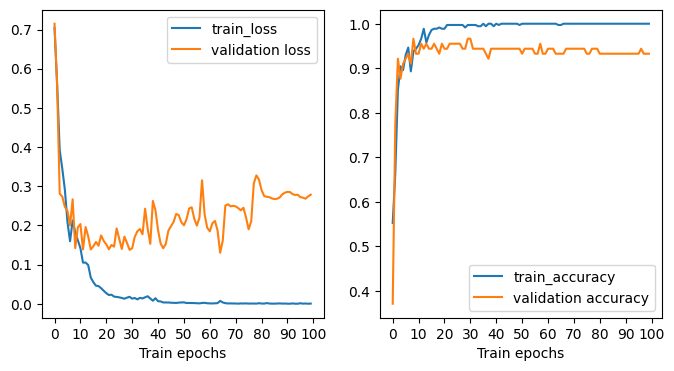

Training...
Accuracy: 0.9032257795333862


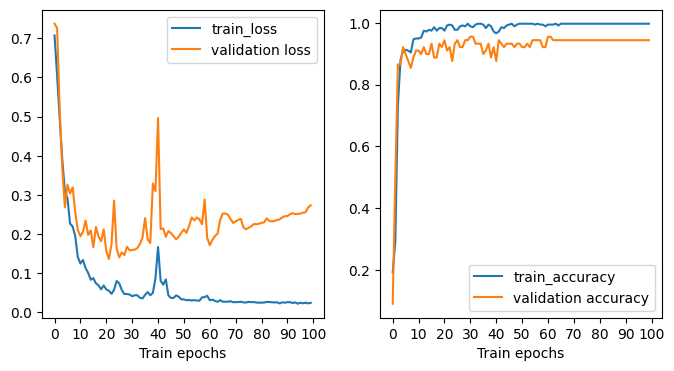

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830645024776459
Training...


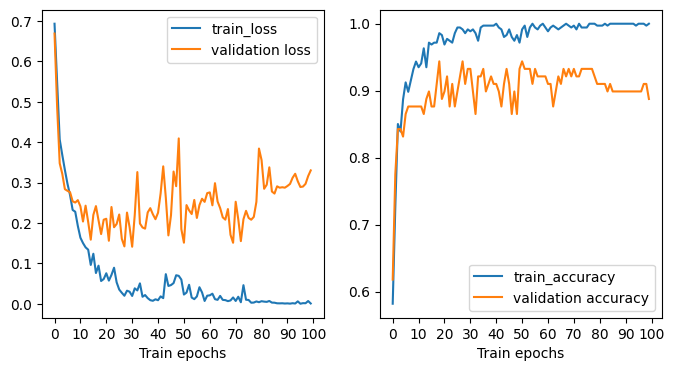

Training...
Accuracy: 0.8790322542190552


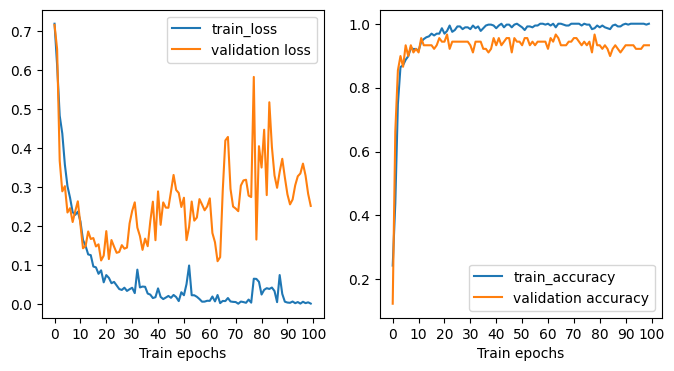

Training...
Accuracy: 0.8709677457809448


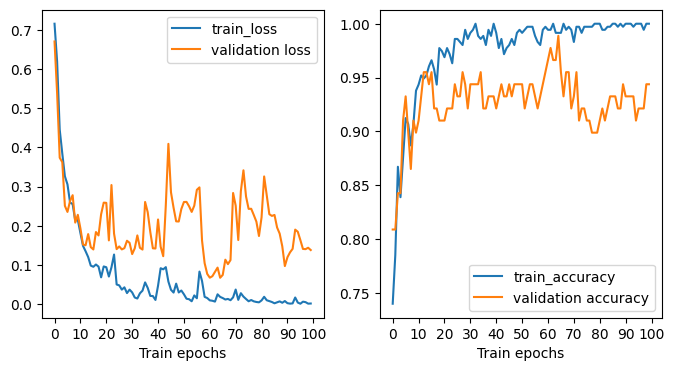

Training...
Accuracy: 0.8709677457809448


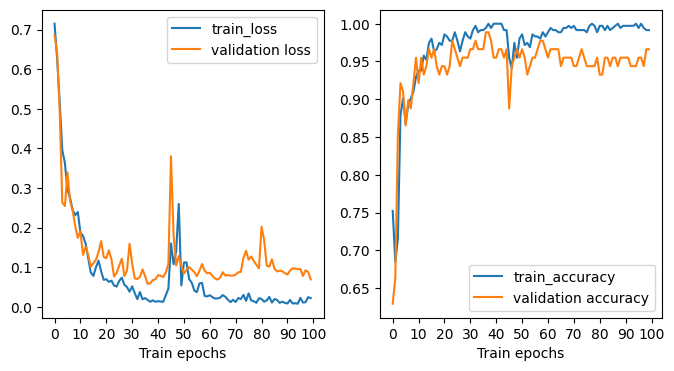

Training...
Accuracy: 0.9354838132858276


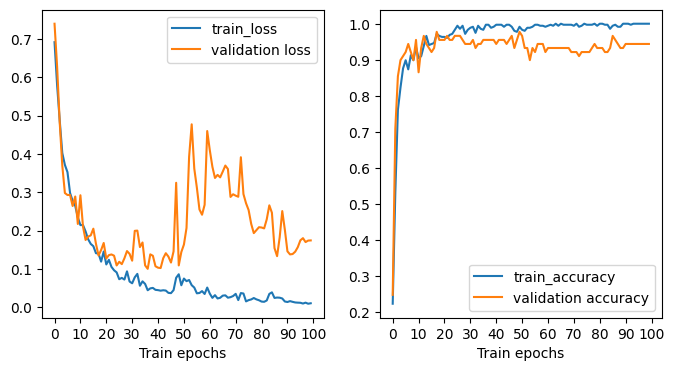

Training...
Accuracy: 0.8870967626571655


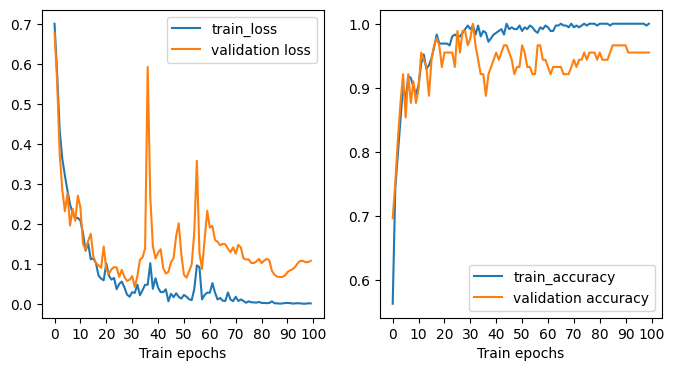

Training...
Accuracy: 0.8709677457809448


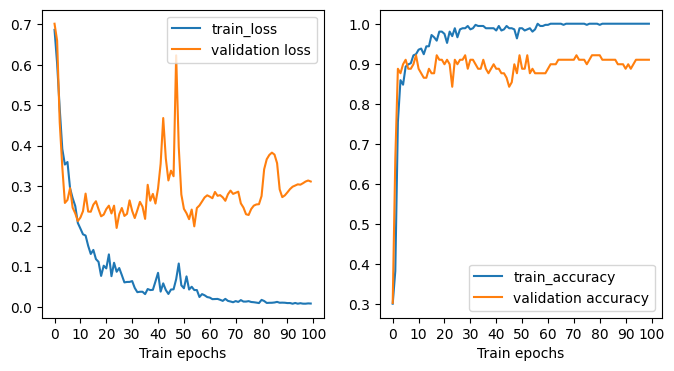

Training...
Accuracy: 0.8870967626571655


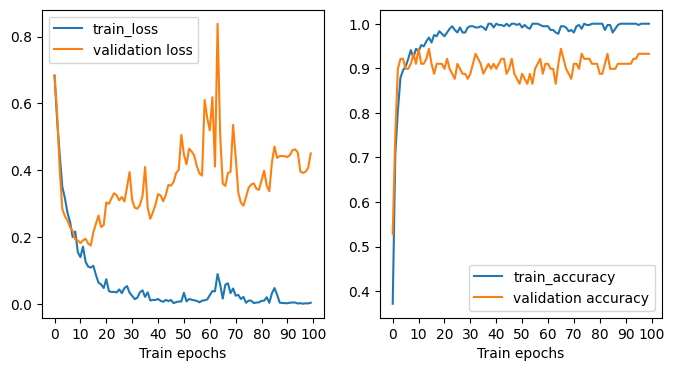

Training...
Accuracy: 0.8790322542190552


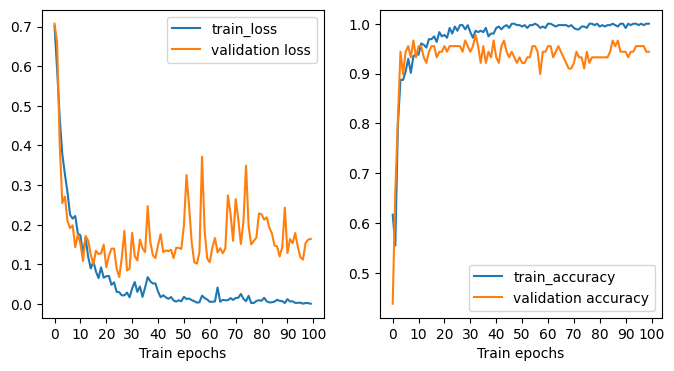

Training...
Accuracy: 0.9032257795333862


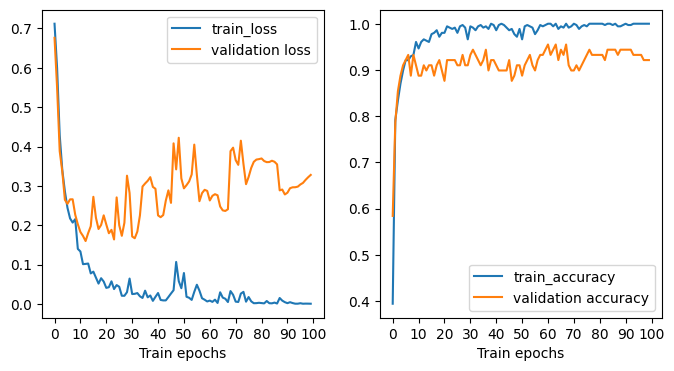

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.884677404165268
Training...
A

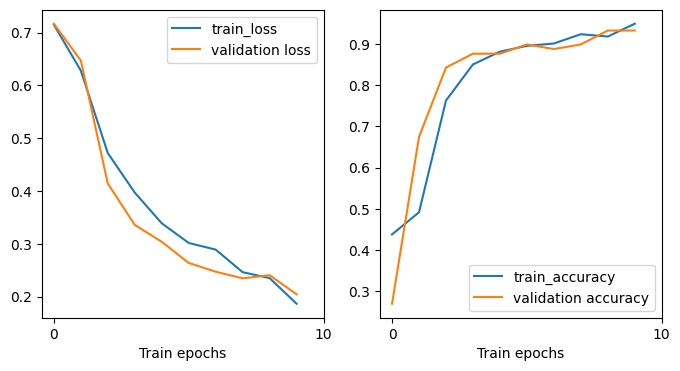

Training...
Accuracy: 0.8548386693000793


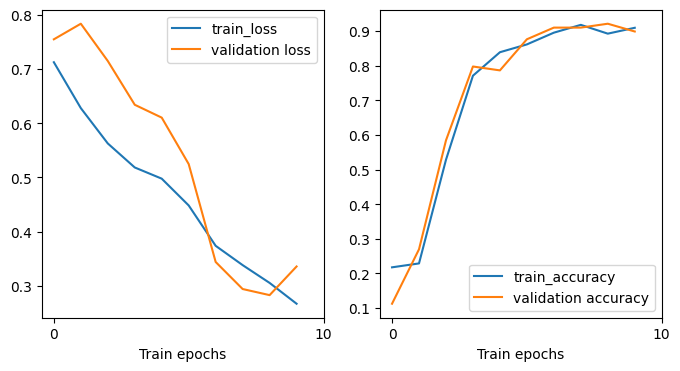

Training...
Accuracy: 0.8709677457809448


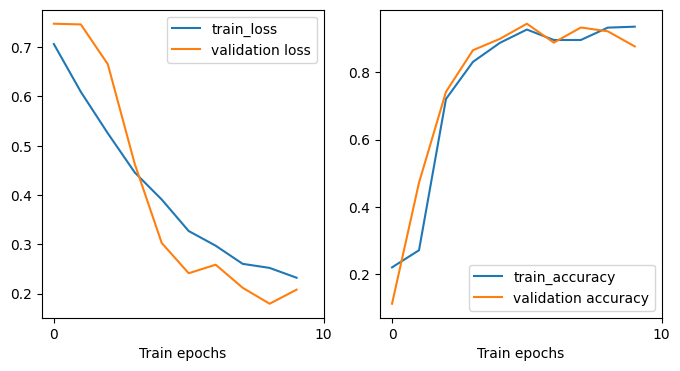

Training...
Accuracy: 0.8548386693000793


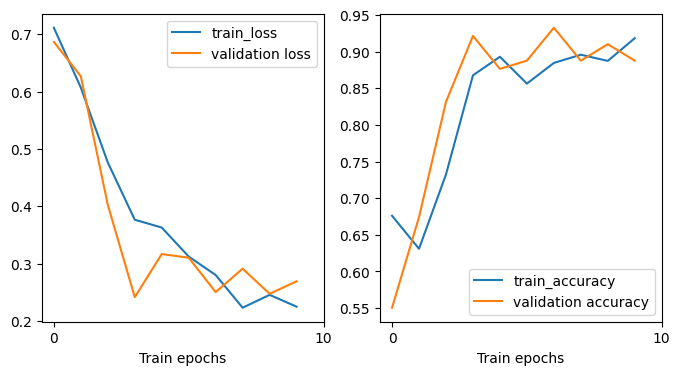

Training...
Accuracy: 0.8709677457809448


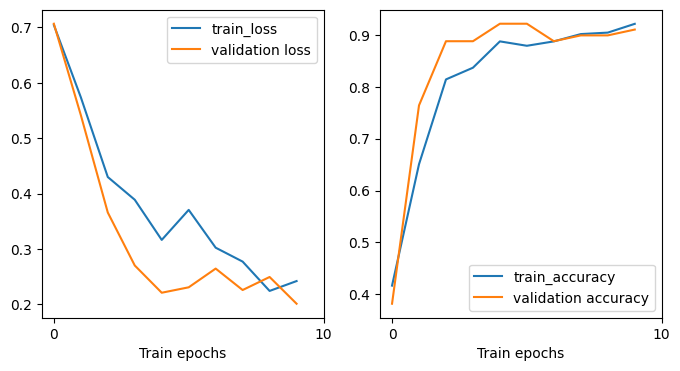

Training...
Accuracy: 0.8145161271095276


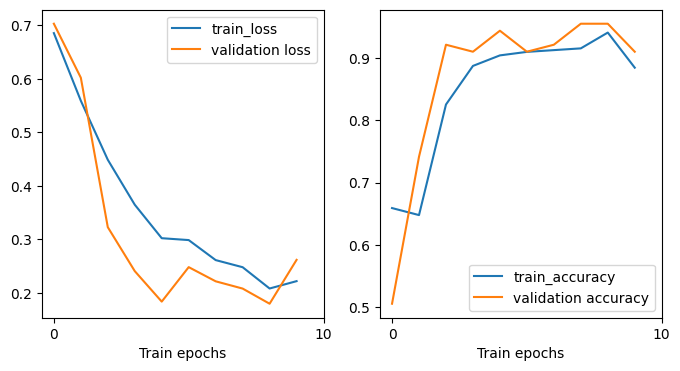

Training...
Accuracy: 0.8709677457809448


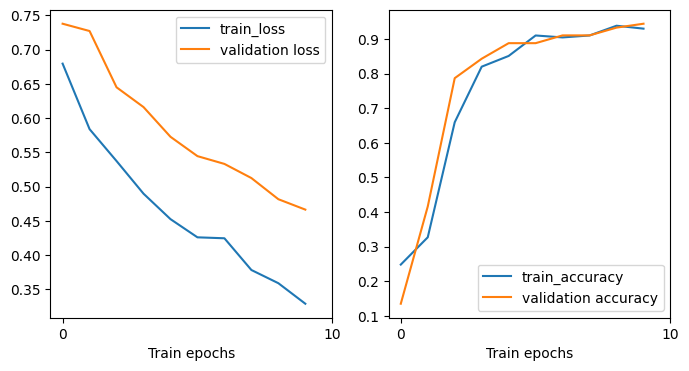

Training...
Accuracy: 0.8790322542190552


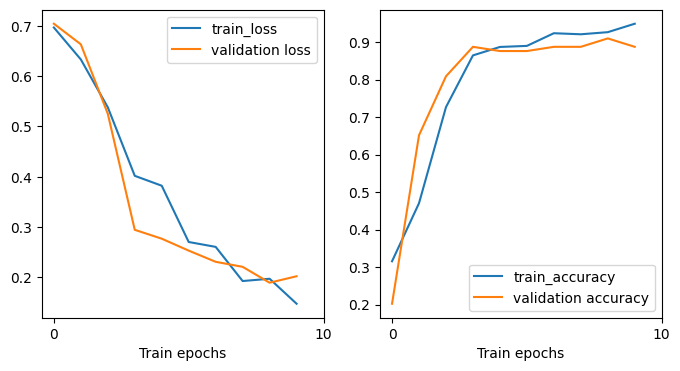

Training...
Accuracy: 0.8709677457809448


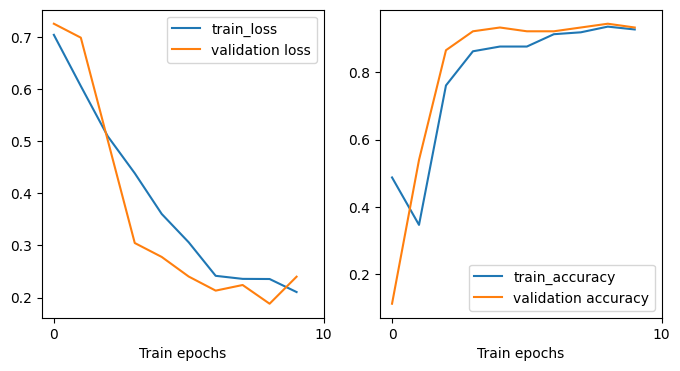

Training...
Accuracy: 0.8548386693000793


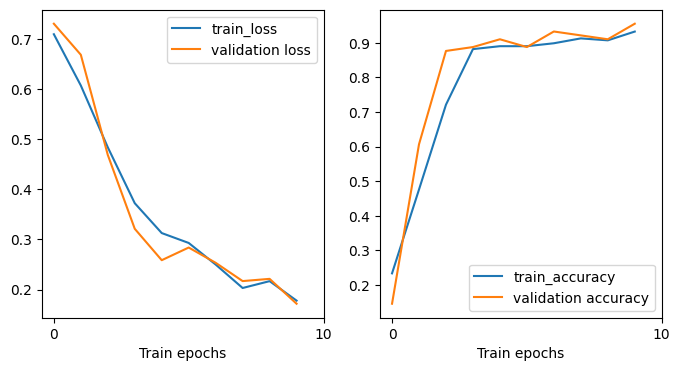

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 85)                2210      
                                                                 
 dropout (Dropout)           (None, 85)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                860       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,081
Trainable params: 3,081
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8620967626571655
Training...


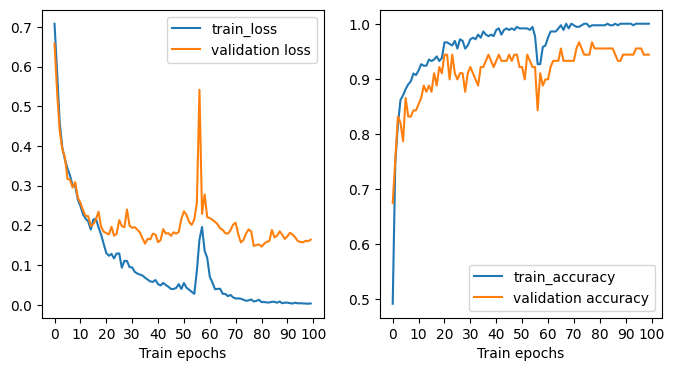

Training...
Accuracy: 0.8870967626571655


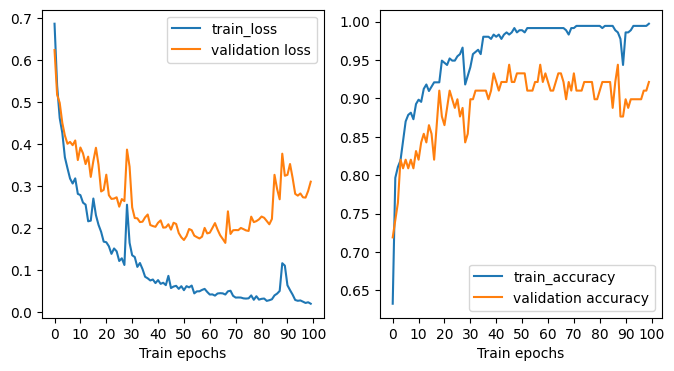

Training...
Accuracy: 0.9112902879714966


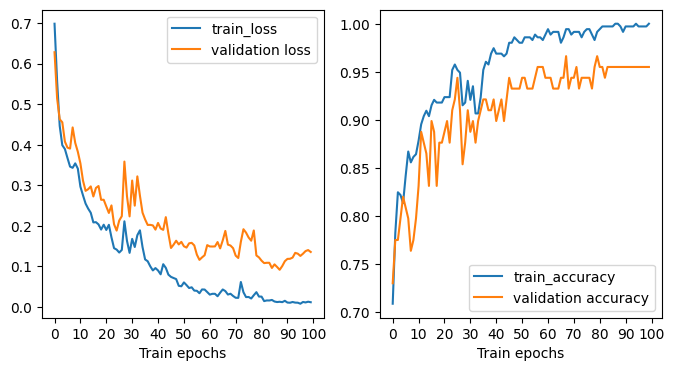

Training...
Accuracy: 0.8709677457809448


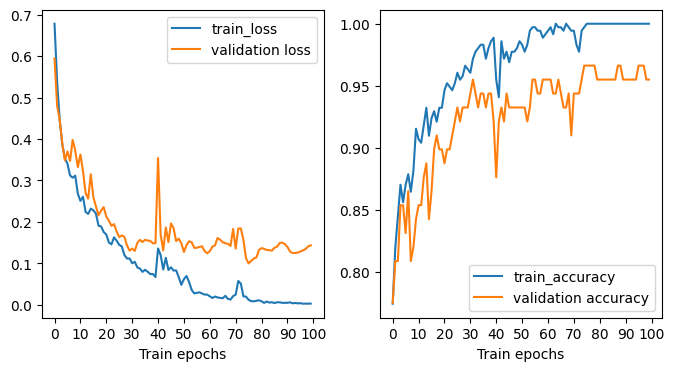

Training...
Accuracy: 0.8790322542190552


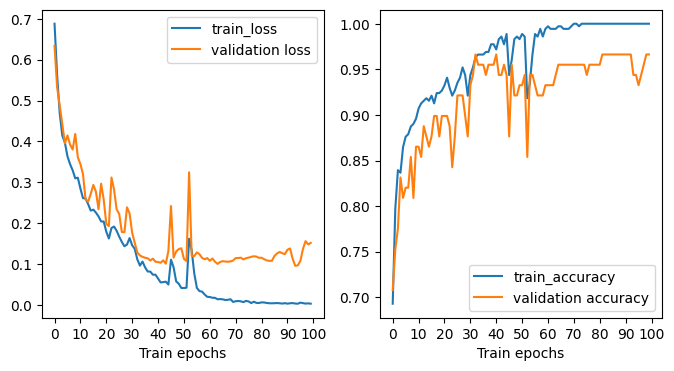

Training...
Accuracy: 0.8790322542190552


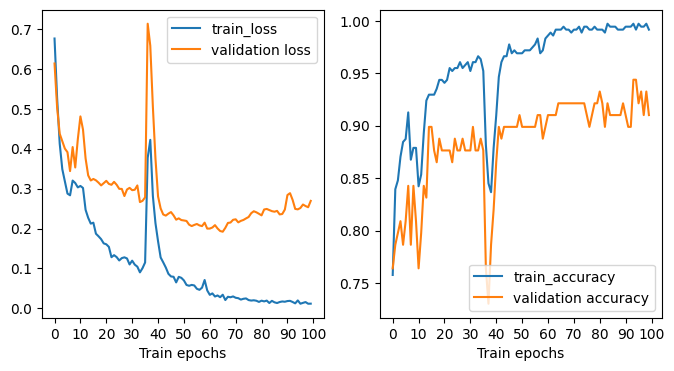

Training...
Accuracy: 0.8790322542190552


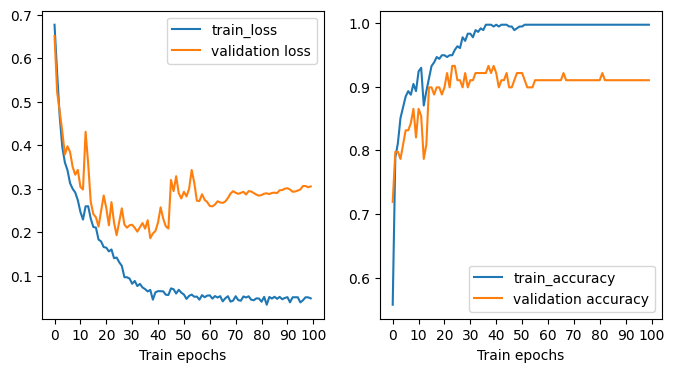

Training...
Accuracy: 0.8790322542190552


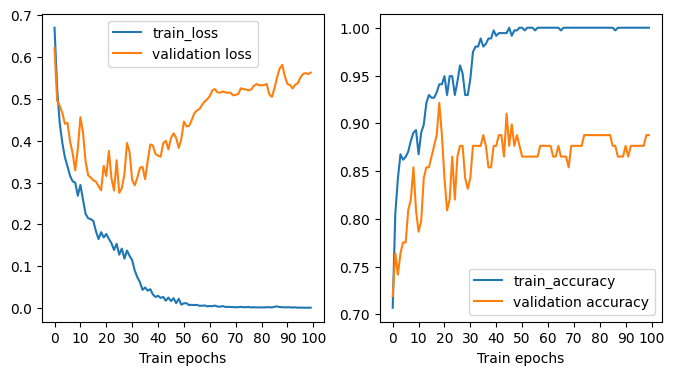

Training...
Accuracy: 0.8951612710952759


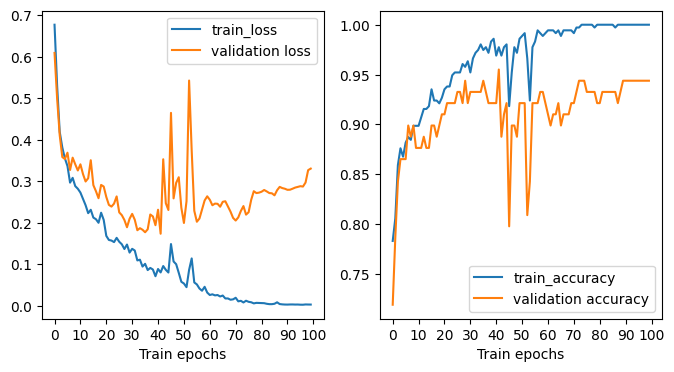

Training...
Accuracy: 0.8790322542190552


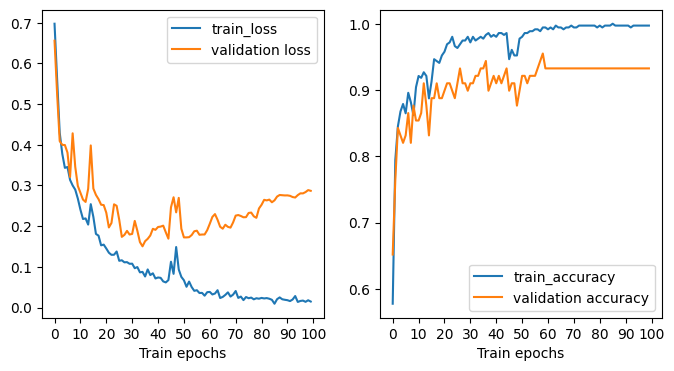

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8838709592819214
Training...


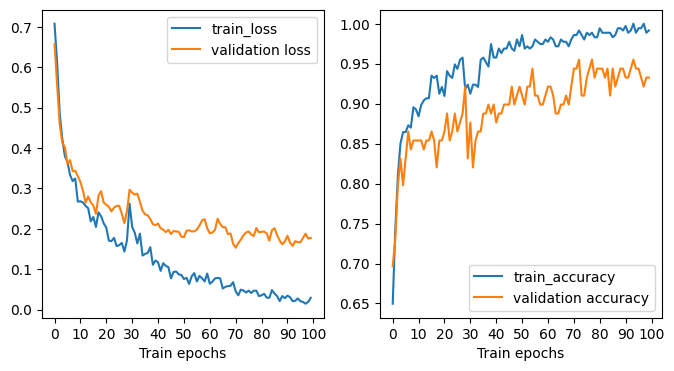

Training...
Accuracy: 0.8709677457809448


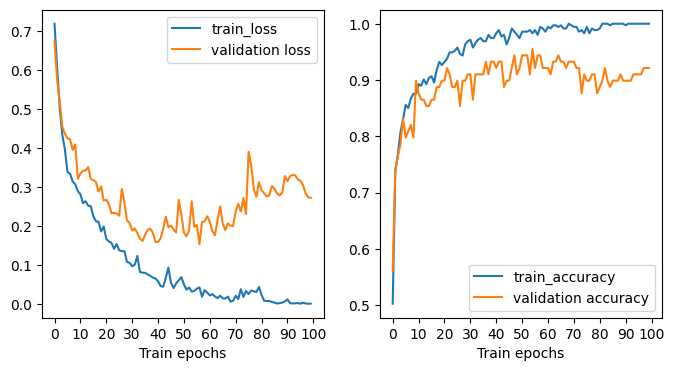

Training...
Accuracy: 0.8870967626571655


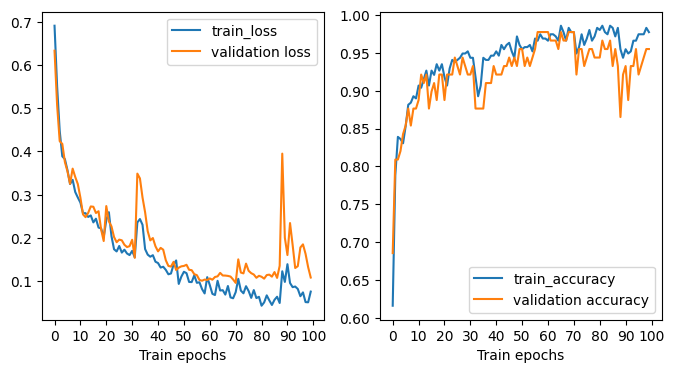

Training...
Accuracy: 0.8951612710952759


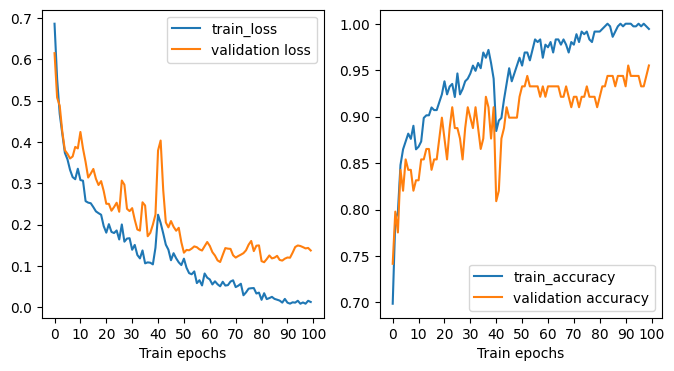

Training...
Accuracy: 0.8790322542190552


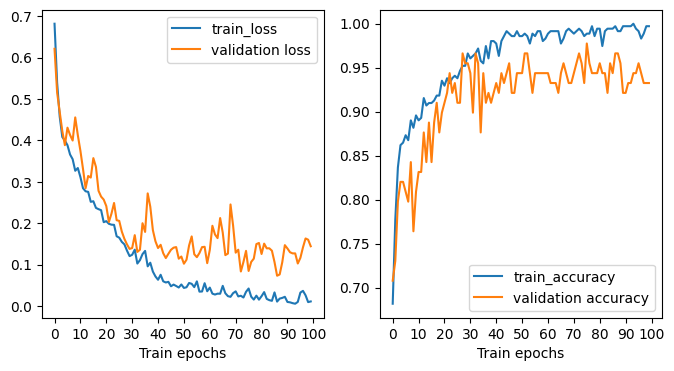

Training...
Accuracy: 0.8387096524238586


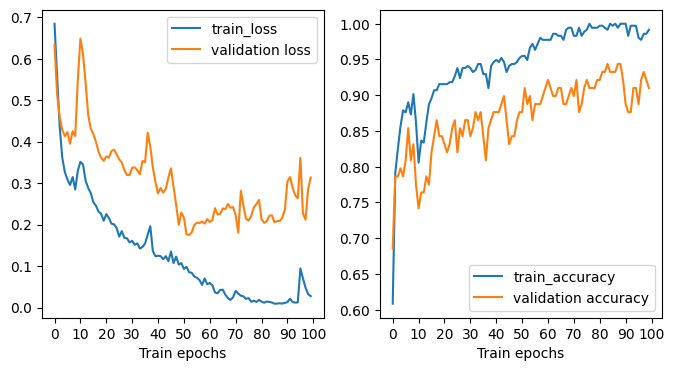

Training...
Accuracy: 0.8870967626571655


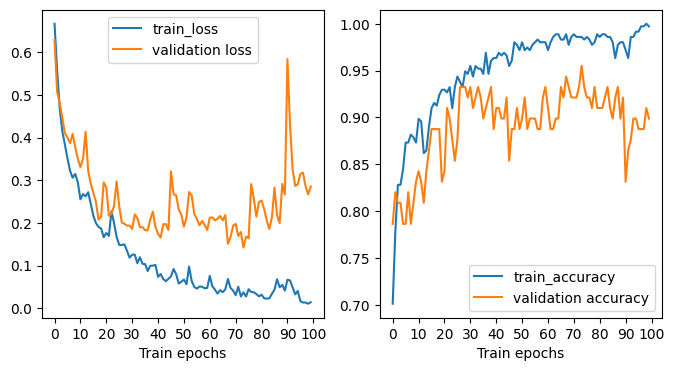

Training...
Accuracy: 0.9032257795333862


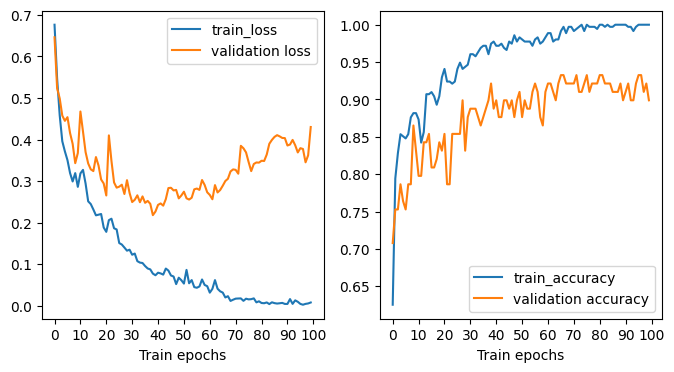

Training...
Accuracy: 0.8951612710952759


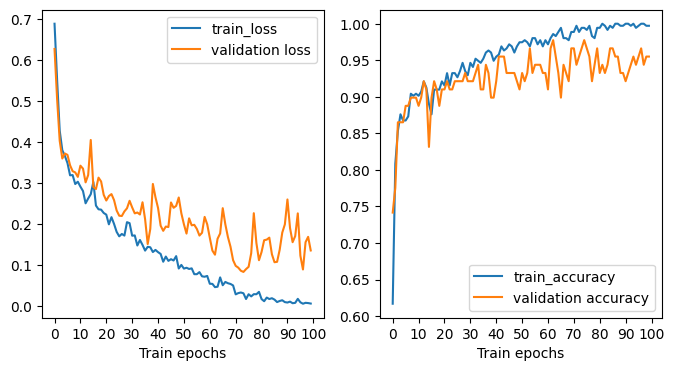

Training...
Accuracy: 0.8790322542190552


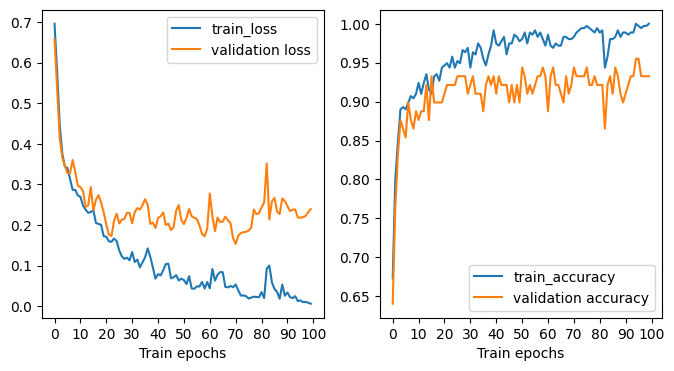

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8830645024776459
Training...


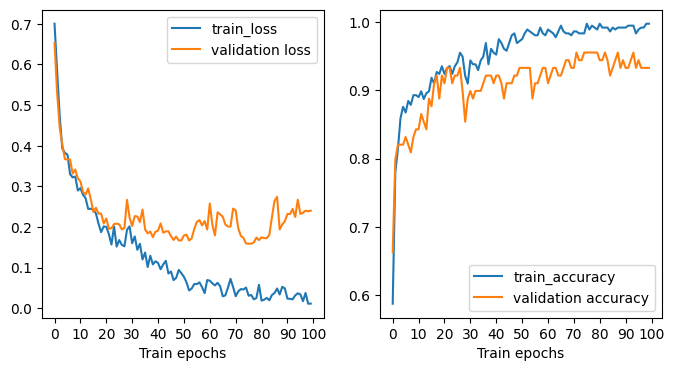

Training...
Accuracy: 0.8870967626571655


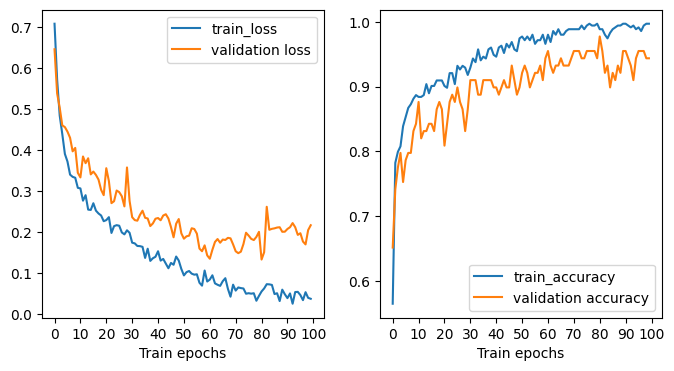

Training...
Accuracy: 0.9112902879714966


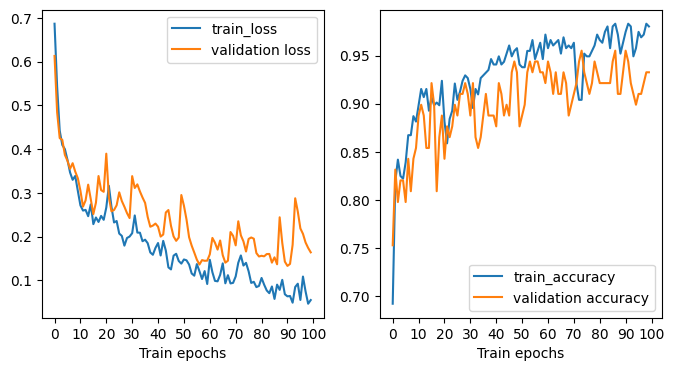

Training...
Accuracy: 0.8790322542190552


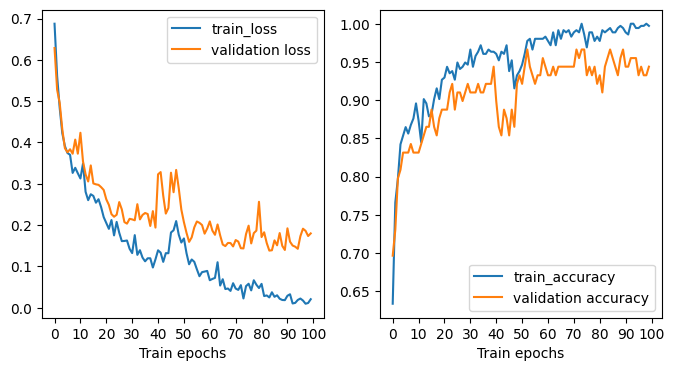

Training...
Accuracy: 0.8790322542190552


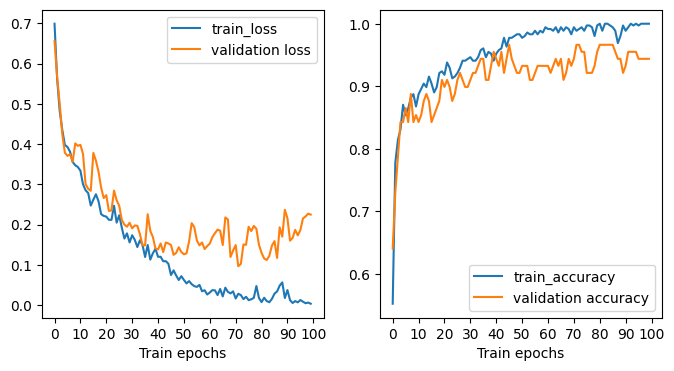

Training...
Accuracy: 0.8629031777381897


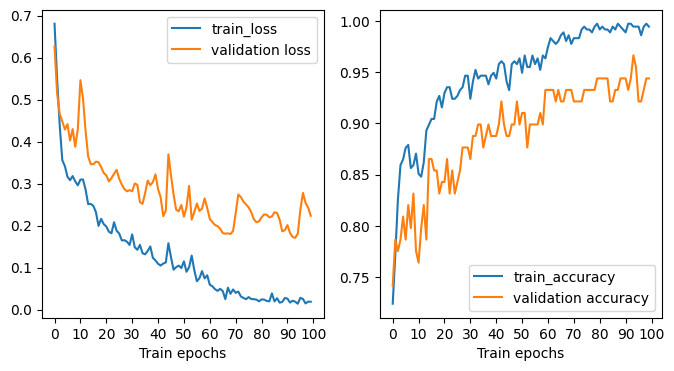

Training...
Accuracy: 0.8951612710952759


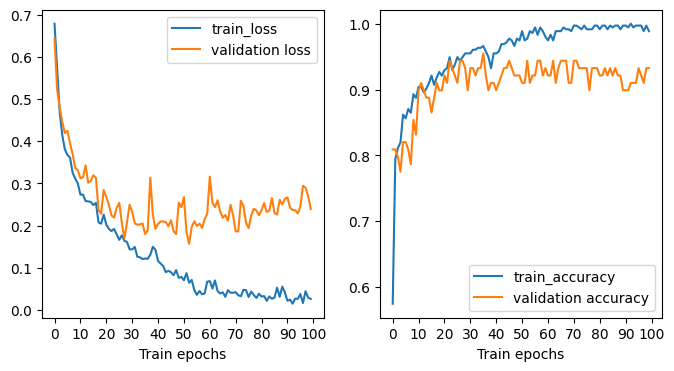

Training...
Accuracy: 0.8870967626571655


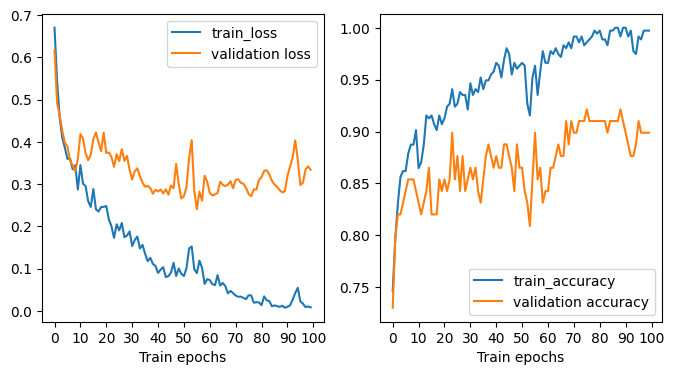

Training...
Accuracy: 0.846774160861969


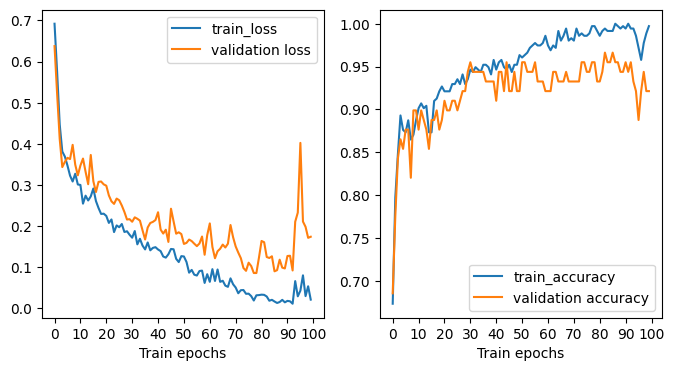

Training...
Accuracy: 0.8870967626571655


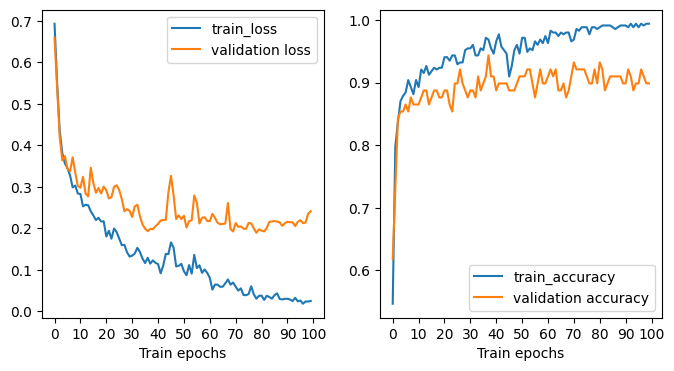

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 95)                2470      
                                                                 
 dropout (Dropout)           (None, 95)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                960       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,441
Trainable params: 3,441
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8806451439857483
Training...


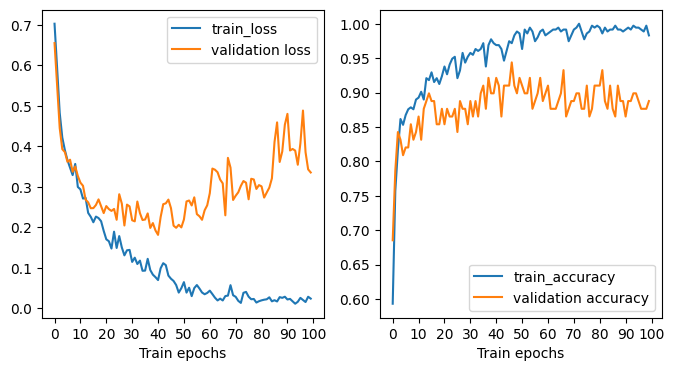

Training...
Accuracy: 0.8870967626571655


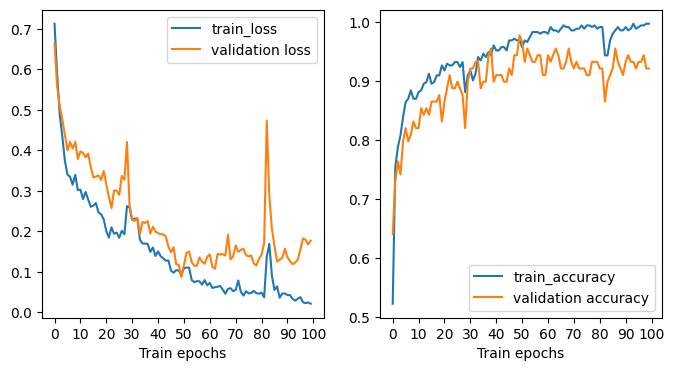

Training...
Accuracy: 0.9032257795333862


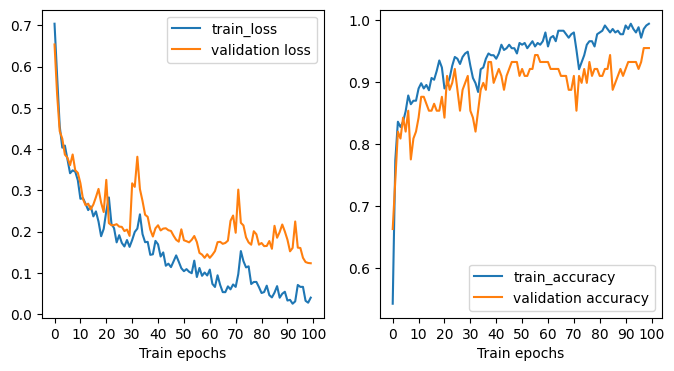

Training...
Accuracy: 0.8951612710952759


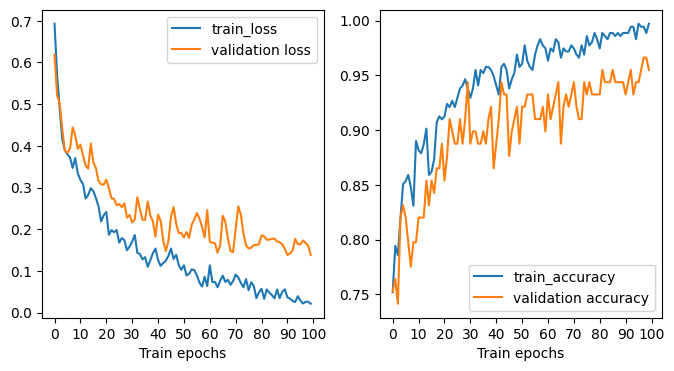

Training...
Accuracy: 0.8951612710952759


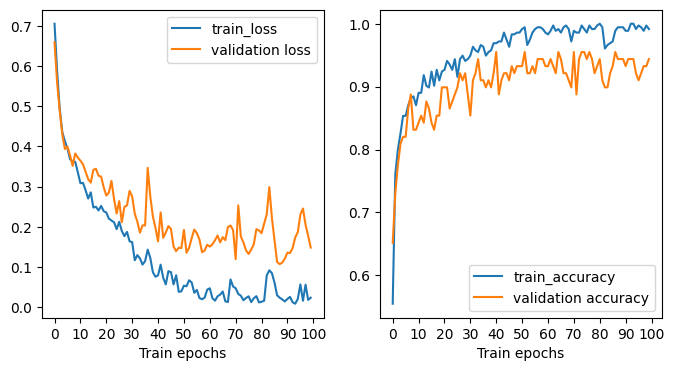

Training...
Accuracy: 0.8951612710952759


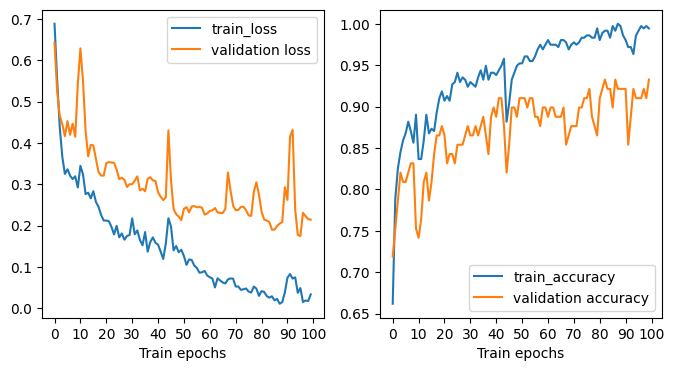

Training...
Accuracy: 0.8629031777381897


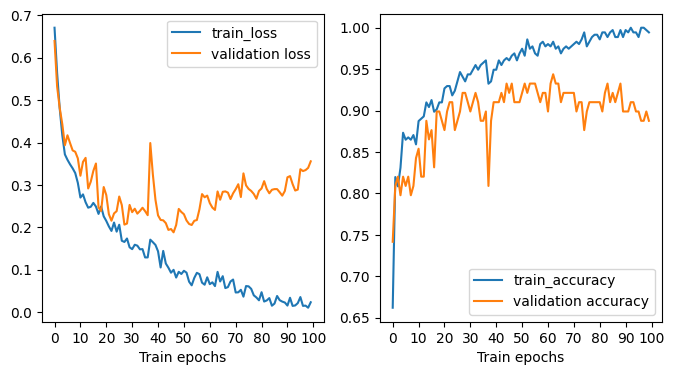

Training...
Accuracy: 0.8951612710952759


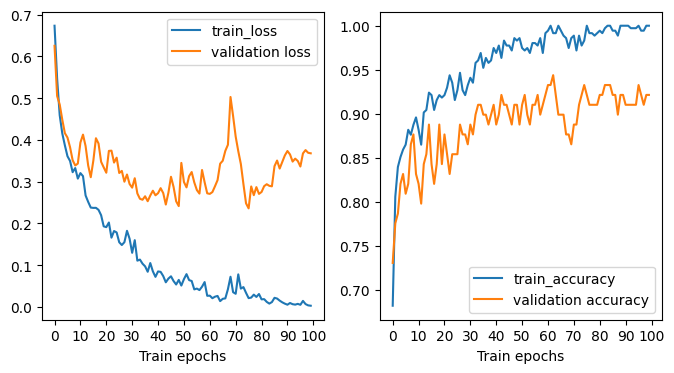

Training...
Accuracy: 0.8709677457809448


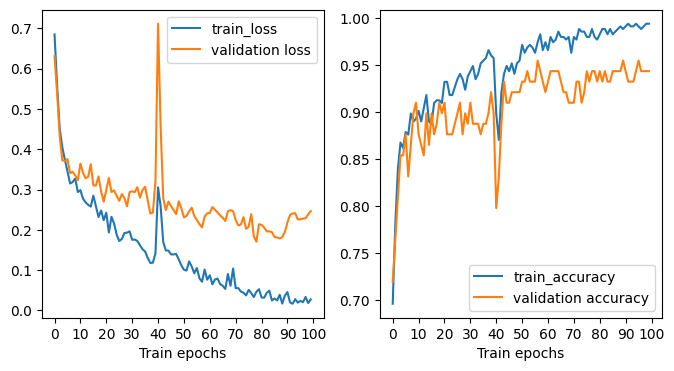

Training...
Accuracy: 0.8951612710952759


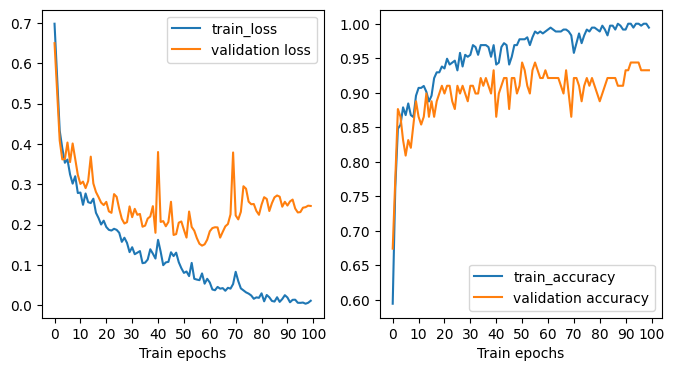

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2600      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 3,621
Trainable params: 3,621
Non-trainable params: 0
_________________________________________________________________
None
Average Accuracy: 0.8887096583843231


In [31]:
# Build Ablation table for accuracy results
# ffnn -> Feed Forward Neural Network 
    #train_and_evaluate(hidden_layer_sizes=[95,10],
    #    activation='relu',
    #    optimizer='Adam',
    #    learning_rate=0.006404687722635315,
    #    dropout_rate=0.25,
    #    num_epochs=100,
    #    num_folds=10)
models = [
    {"name": "Model 1 - FFNN/relu/Adam/hls-95,10/lr-0.006404687722635315/dr-0.1", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.1,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 2 - FFNN/relu/Adam/hls-95,10/lr-0.006404687722635315/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 3 - FFNN/relu/Adam/hls-85,10/lr-0.006404687722635315/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[85,10],
    activation='relu',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.25,
    num_epochs=10,
    num_folds=10)},
    {"name": "Model 4 - FFNN/tanh/Adam/hls-95/lr-0.006404687722635315/dr-0.1", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.1,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 5 - FFNN/tanh/Adam/hls-95,10/lr-0.006404687722635315/dr-0.2", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.2,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 6 - FFNN/tanh/Adam/hls-95,10/lr-0.006404687722635315/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[95,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10)},
    {"name": "Model 7 - FFNN/tanh/Adam/hls-100,10/lr-0.006404687722635315/dr-0.25", "model": train_and_evaluate(
    hidden_layer_sizes=[100,10],
    activation='tanh',
    optimizer='Adam',
    learning_rate=0.006404687722635315,
    dropout_rate=0.25,
    num_epochs=100,
    num_folds=10),
    }
]


In [32]:
study = []
for model_info in models:
    model_name = model_info["name"]
    model = model_info["model"]
    #model.train_and_evaluate(X_train_pca, y_train)
    
    accuracy = model.evaluate(X_test_pca, Y_test)
    study.append({"Model": model_name, "Accuracy": accuracy})

# Create the ablation table using Pandas and tabulate
table_df = pd.DataFrame(study)
ablation_table = tabulate(table_df, headers="keys", tablefmt="pipe")

# Print the ablation table
print(ablation_table)

4/4 [==============================] - 0s 6ms/step - loss: 0.5198 - binary_accuracy: 0.8952
|    | Model                                                               | Accuracy                                 |
|---:|:--------------------------------------------------------------------|:-----------------------------------------|
|  0 | Model 1 - FFNN/relu/Adam/hls-95,10/lr-0.006404687722635315/dr-0.1   | [1.0477771759033203, 0.9032257795333862] |
|  1 | Model 2 - FFNN/relu/Adam/hls-95,10/lr-0.006404687722635315/dr-0.25  | [1.6358096599578857, 0.9032257795333862] |
|  2 | Model 3 - FFNN/relu/Adam/hls-85,10/lr-0.006404687722635315/dr-0.25  | [0.4357265532016754, 0.8548386693000793] |
|  3 | Model 4 - FFNN/tanh/Adam/hls-95/lr-0.006404687722635315/dr-0.1      | [0.4544062316417694, 0.8790322542190552] |
|  4 | Model 5 - FFNN/tanh/Adam/hls-95,10/lr-0.006404687722635315/dr-0.2   | [0.4246421754360199, 0.8790322542190552] |
|  5 | Model 6 - FFNN/tanh/Adam/hls-95,10/lr-0.006404687722635315/dr